# 2019 Computer Vision (AAA534)

## Chapter 7. Transformations and warping

Code by JunYeup Cho, JongMin Lee

In [1]:
# import opencv, numpy
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# utility function for displaying multiple images
def ShowImgs(images, titles, row, column, size):
    fig = plt.figure(figsize = size)
    for i in range(len(images)):
        # cmap = 'gray' is ignored if image is 3D
        fig.add_subplot(row, column, i+1), plt.imshow(images[i], cmap = 'gray'), plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

    plt.show()

### Part 1. Image Wraping

In [3]:
# scaling
img = cv2.imread('logo.jpg')

height, width = img.shape[:2]

shrink = cv2.resize(img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

zoom = cv2.resize(img, (width*2, height*2), interpolation=cv2.INTER_CUBIC)

cv2.imshow('Origianl', img)
cv2.imshow('Shrink', shrink)
cv2.imshow('Zoom', zoom)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
# Translation
img = cv2.imread('logo.jpg')

rows, cols = img.shape[:2]

M = np.float32([[1,0,10],[0,1,20]])

dst = cv2.warpAffine(img, M,(cols, rows))
cv2.imshow('Original', img)
cv2.imshow('Translation', dst)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
# rotation
img = cv2.imread('logo.jpg')

rows, cols = img.shape[:2]

# creating roation matrix  with cv2.getRotationMatrix2D()
M= cv2.getRotationMatrix2D((cols/2, rows/2),90, 0.5)

dst = cv2.warpAffine(img, M,(cols, rows))

cv2.imshow('Original', img)
cv2.imshow('Rotation', dst)

cv2.waitKey(0)
cv2.destroyAllWindows()

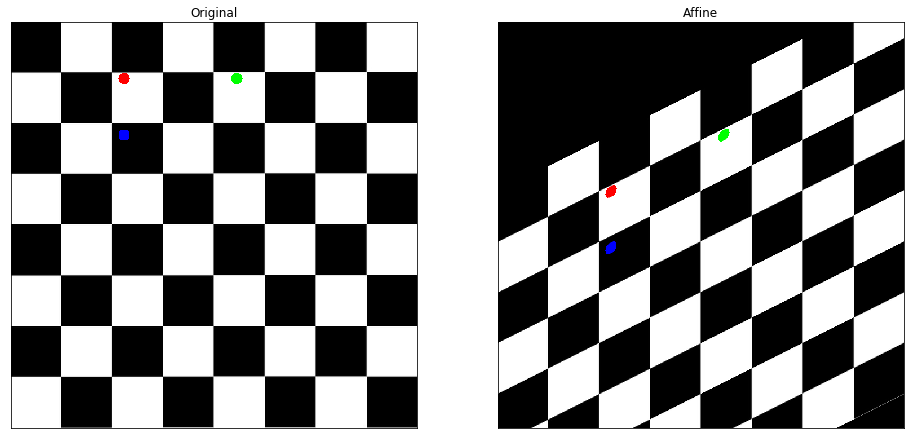

In [6]:
# Affine transform
img = cv2.imread('chessboard.jpg')
rows, cols, ch = img.shape

pts1 = np.float32([[200,100],[400,100],[200,200]])
pts2 = np.float32([[200,300],[400,200],[200,400]])

# Points are also transformed. 
cv2.circle(img, (200,100), 10, (255,0,0),-1)
cv2.circle(img, (400,100), 10, (0,255,0),-1)
cv2.circle(img, (200,200), 10, (0,0,255),-1)

M = cv2.getAffineTransform(pts1, pts2)

dst = cv2.warpAffine(img, M, (cols,rows))

ShowImgs([img, dst], ["Original", "Affine"], 1, 2, (16, 16))

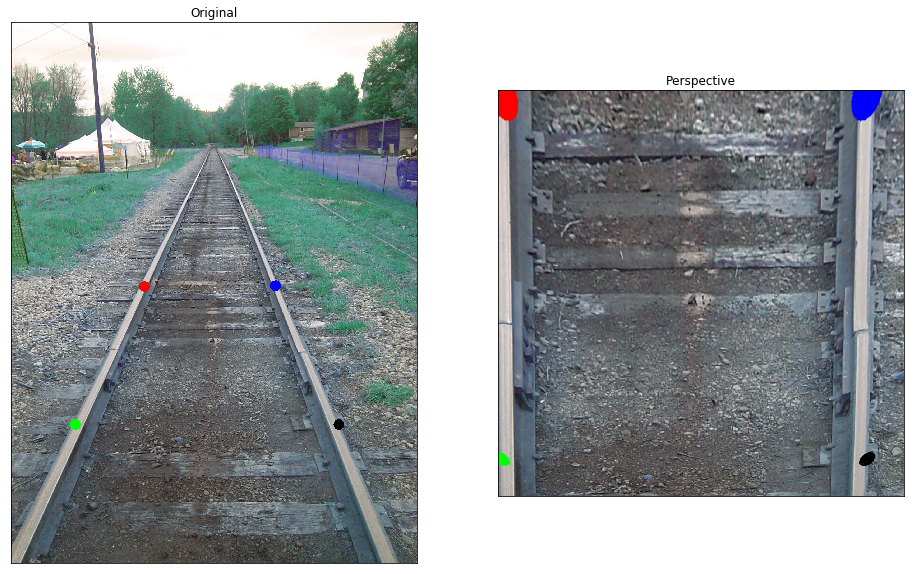

In [7]:
#Perspective transform
img = cv2.imread('perspective.jpg')

pts1 = np.float32([[504,1003],[243,1525],[1000,1000],[1240,1524]])

pts2 = np.float32([[10,10],[10,1000],[1000,10],[1000,1000]])

cv2.circle(img, (504,1003), 20, (255,0,0),-1)
cv2.circle(img, (243,1524), 20, (0,255,0),-1)
cv2.circle(img, (1000,1000), 20, (0,0,255),-1)
cv2.circle(img, (1240,1524), 20, (0,0,0),-1)

M = cv2.getPerspectiveTransform(pts1, pts2)

dst = cv2.warpPerspective(img, M, (1100,1100))

ShowImgs([img, dst], ["Original", "Perspective"], 1, 2, (16, 16))

### Part 2. Homographies

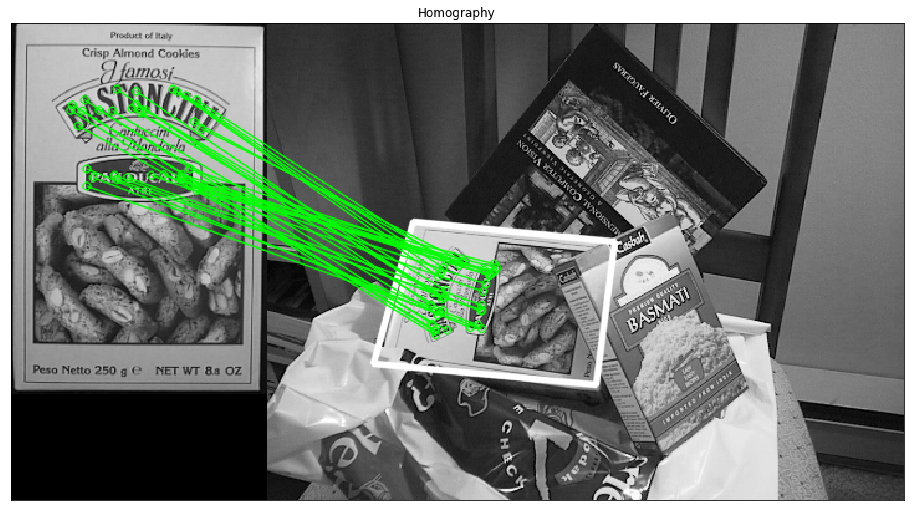

In [10]:
MIN_MATCH_COUNT = 10

img1 = cv2.imread('box.png',0)          # queryImage
img2 = cv2.imread('box_in_scene.png',0) # trainImage

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# store all the good matches as per Lowe's ratio test.
good = []
for m in matches:
    good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

ShowImgs([img3], ["Homography"], 1, 1, (16, 16))